In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state, test_size
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *
from src.models import ExpandingPredictionARIMA, SKLearnWrapARIMA

In [4]:
# Load data
model_type = "arma"
tinterval = 'daily'

year_start = 2012
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

variables = 'FF_TS_VX' #'FF' # 'FF_TS_VX'

name = f'{tinterval}_{variables}_{year_spread}'

df_w = load_data(file_name=f"df_{name}.csv", file_path=OUT_DATA_DIR)
data_dict = load_data(file_name=f"dict_{name}.pkl", file_path=OUT_DATA_DIR)

In [5]:
# update dict with model specific information
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(variables=variables)
data_dict["model_metrics"].update(tinterval=tinterval)
data_dict["model_metrics"].update(model_name=f"{model_type}_{name}_{data_dict['model_features']['predicted']}")

# data selection

In [6]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    'sp_close'
]
categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

# TTS

In [7]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [8]:
df_train = df_ws.copy()

In [9]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=test_size,
                                            add_const=False)

# Corr

In [10]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

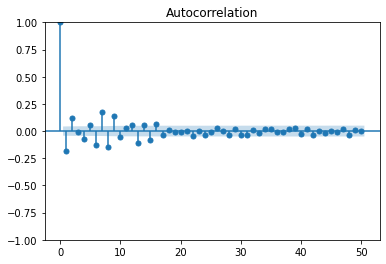

In [11]:
auto_corr(X_train.sp_close, no_lags=50, partial=False);

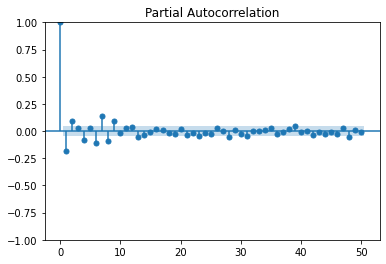

In [12]:
auto_corr(X_train.sp_close, no_lags=50, partial=True);

# Model

In [13]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [14]:
from statsmodels.tsa.arima.model import ARIMA

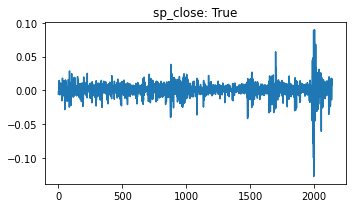

Stationarity Test Results
P-Values: 2.3247247115626374e-23
Test-stats: -12.540101960283666
Time series is stationary: True
Number of lags used: 13


True

In [15]:
stest = StatsTest(print_results=True)
stest.arr_stationarity_adfuller(X_train.sp_close)

In [16]:
x = ARIMA(X_train.sp_close, order=(1,0,1))
x_t = x.fit()

In [17]:
x_t.forecast()

2139   -0.001
dtype: float64

In [18]:
max_order = (10,0,10)
# index p
# cols q
df_aic = pd.DataFrame(index=range(0, max_order[0]+1), columns=range(0, max_order[0]+1))
df_mse = pd.DataFrame(index=range(0, max_order[0]+1), columns=range(0, max_order[0]+1))
df_err = pd.DataFrame(index=range(0, max_order[0]+1), columns=range(0, max_order[0]+1))
for p in range(0, max_order[0] + 1):
    aic_results = []
    mse_results = []
    no_error = []
    for q in range(0, max_order[2]+1):
        mod = ARIMA(X_train.sp_close, order=(p,0,q))
        mod_trained = mod.fit()
        
        if mod_trained.mle_retvals['converged'] == True:
            no_error.append(True)
        else:
            no_error.append(False)
            
        aic_results.append(float(mod_trained.aic))
        mse_results.append(float(mod_trained.mse))
    
    df_aic.loc[p] = aic_results
    df_mse.loc[p] = mse_results
    df_err.loc[p] = no_error

C:\Users\LukasGrahl\Documents\GIT\bachelor\bachelor_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LukasGrahl\Documents\GIT\bachelor\bachelor_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\LukasGrahl\Documents\GIT\bachelor\bachelor_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\LukasGrahl\Documents\GIT\bachelor\bachelor_env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

In [19]:
df_aic = df_aic.astype(float)
df_mse = df_mse.astype(float)

In [20]:
print("\n DONE")


 DONE


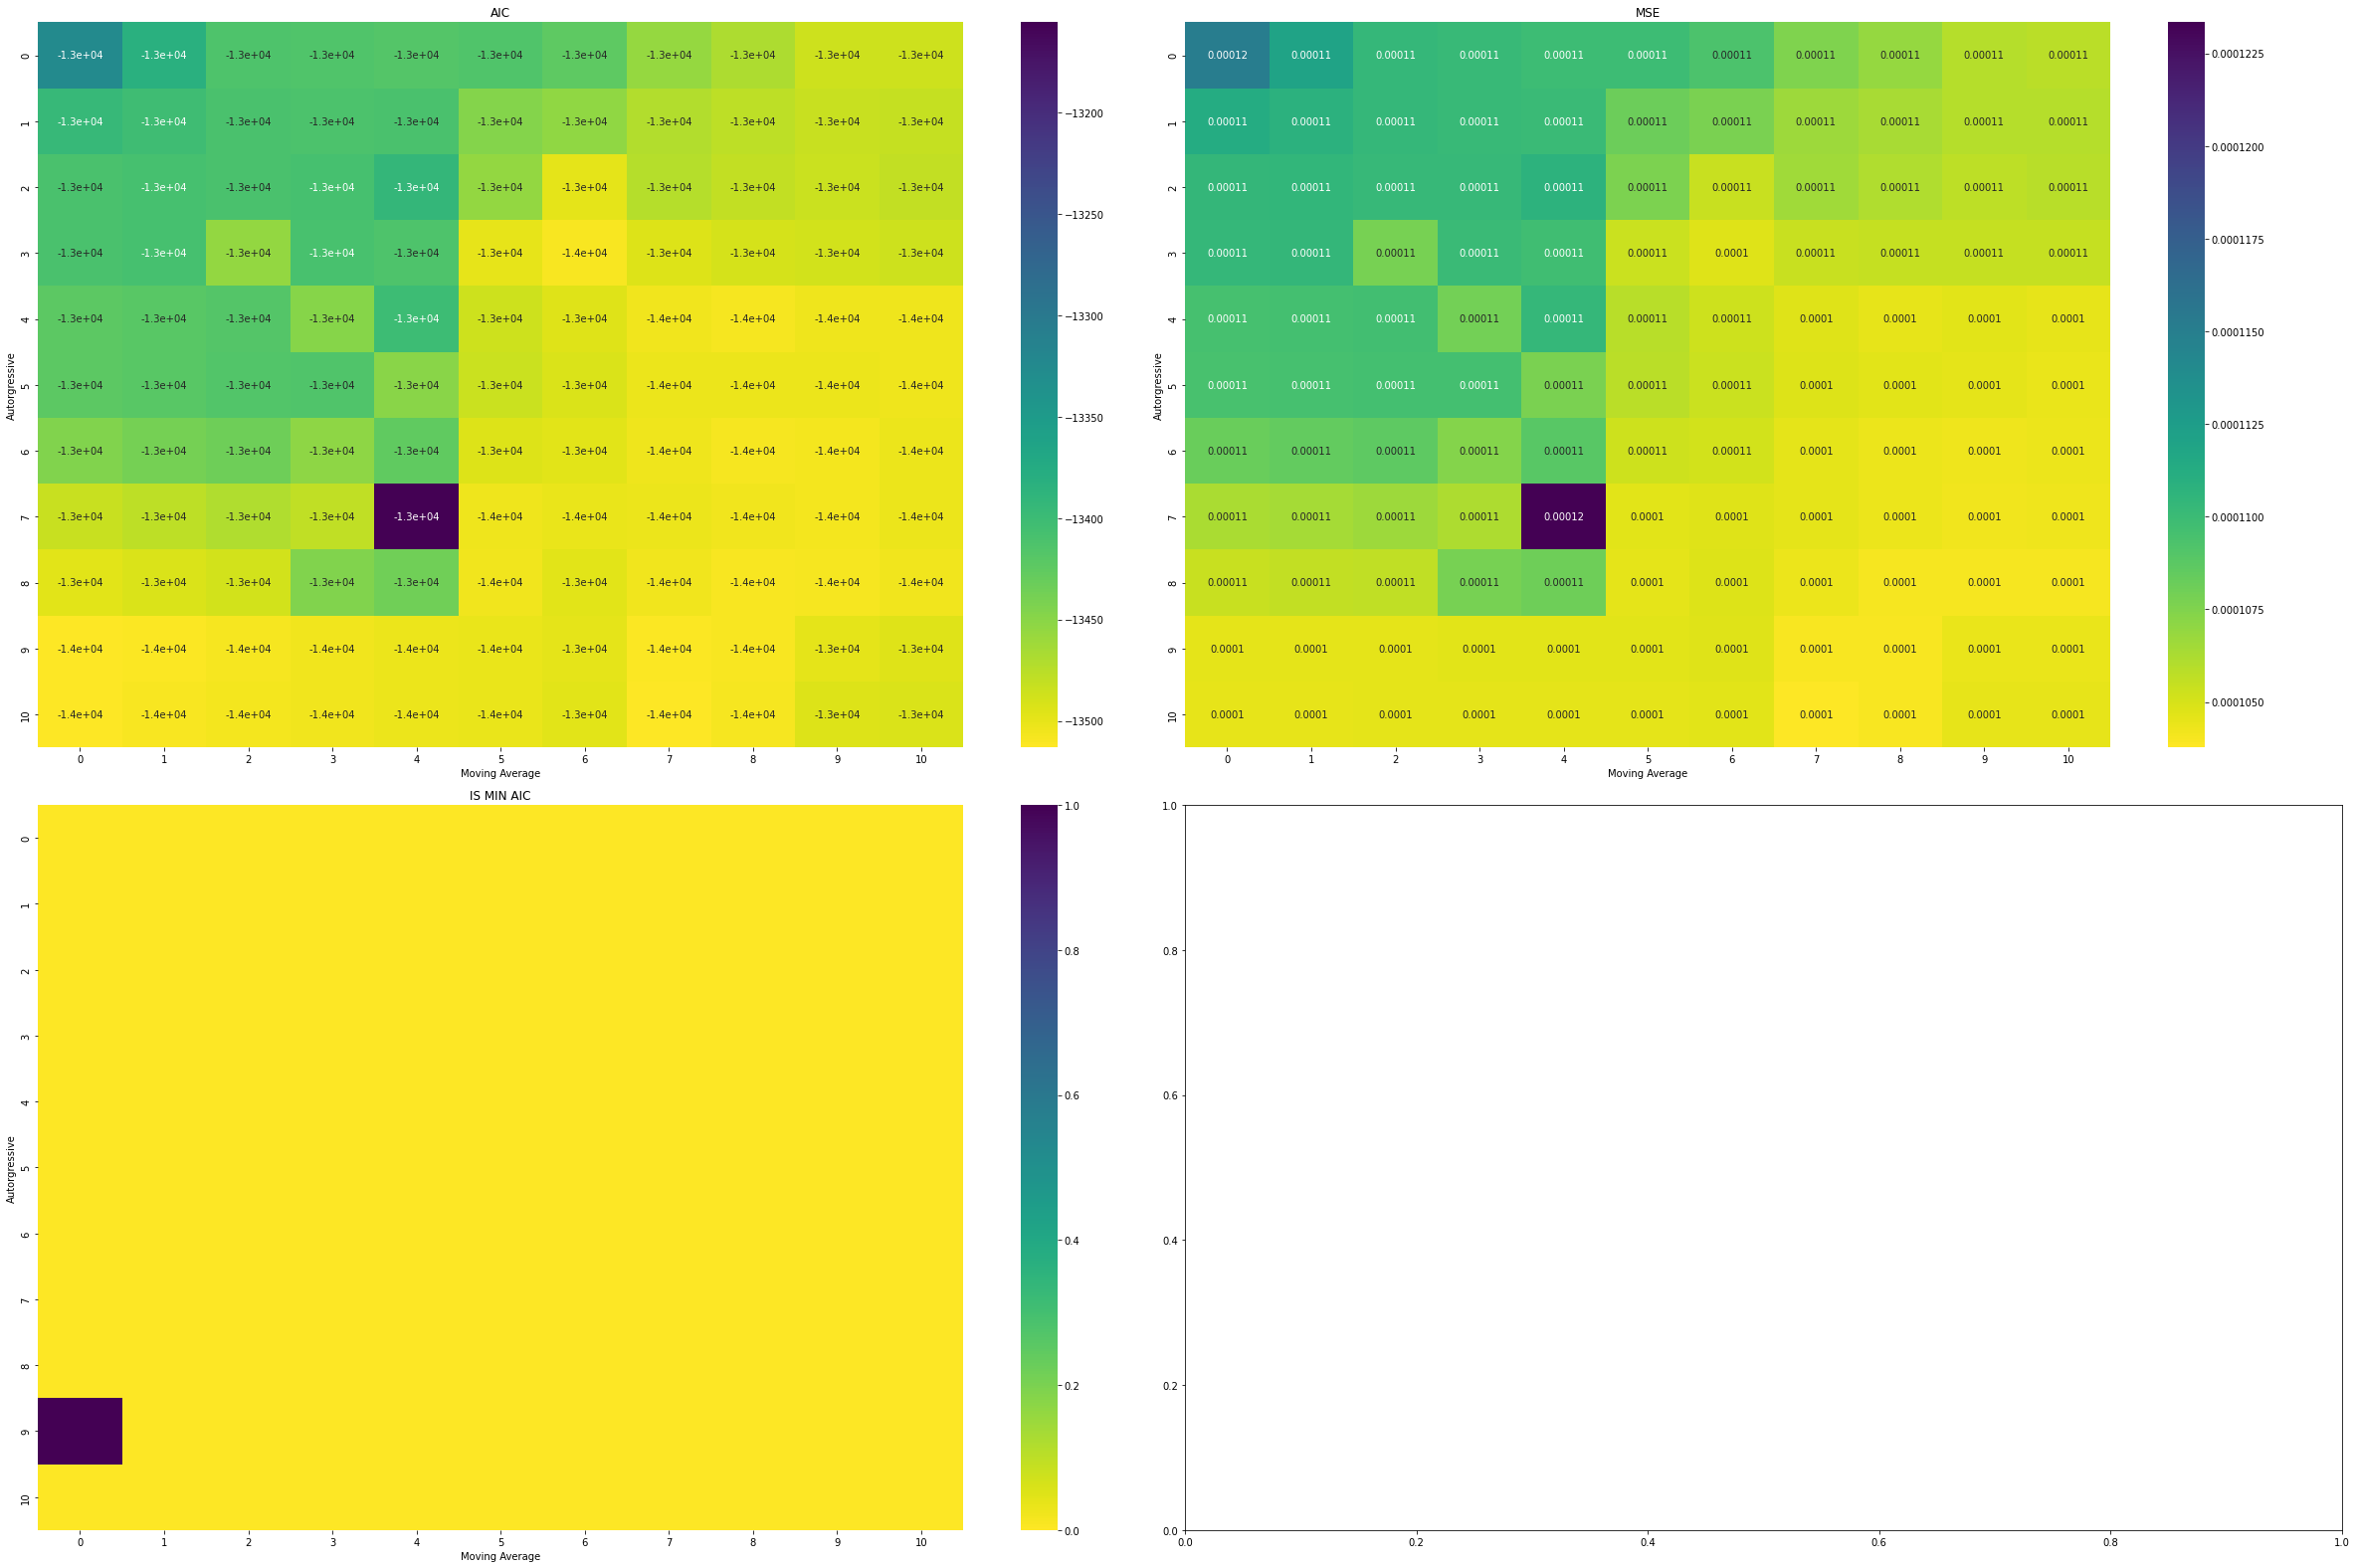

In [45]:
# error corrected output - point to min
_res = (df_aic * df_err).replace({0: np.nan})
aic_res = _res == _res.min().min()

fig_aic, ax = plt.subplots(2, 2, figsize=(1.5 * df_aic.shape[0] * 2, 1 * df_aic.shape[1] * 2))

sns.heatmap(df_aic,
           annot=True,
           ax=ax[0, 0],
           cmap="viridis_r")
ax[0, 0].set_title("AIC")
ax[0, 0].set_ylabel("Autorgressive")
ax[0, 0].set_xlabel('Moving Average')

sns.heatmap(df_mse,
           annot=True,
           ax=ax[0, 1],
           cmap="viridis_r")
ax[0, 1].set_title("MSE")
ax[0, 1].set_ylabel("Autorgressive")
ax[0, 1].set_xlabel('Moving Average')

sns.heatmap(aic_res,
           annot=False,
           ax=ax[1, 0],
           cmap="viridis_r")
ax[1, 0].set_title("IS MIN AIC")
ax[1, 0].set_ylabel("Autorgressive")
ax[1, 0].set_xlabel('Moving Average')

plt.tight_layout()

In [ ]:
# take 1,0,0 instead

# Out of sample eval

In [23]:
model_wrap = ExpandingPredictionARIMA(SKLearnWrapARIMA(ARIMA),
                                      arima_order=(9, 0, 0),
                                      target_var='sp_close',
                                      X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

# Validation

In [24]:
%%capture
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model_wrap,
            print_results=True)

In [25]:
mval.model_wrapper.model.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               sp_close   No. Observations:                 2376
Model:                 ARIMA(9, 0, 0)   Log Likelihood                7551.781
Date:                Tue, 05 Apr 2022   AIC                         -15081.563
Time:                        18:41:47   BIC                         -15018.058
Sample:                             0   HQIC                        -15058.448
                               - 2376                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.183      0.029    5.07e-05       0.001
ar.L1         -0.1200      0.010    -12.391      0.000      -0.139      -0.101
ar.L2          0.0685      0.010      7.167      0.000       0.050       0.087
ar.L3          0.0139      0.010      1.380      0.167      -0.006       0.034
ar.L4         -0.0744      0.011     -6.828      0.000      -0.096      -0.053
ar.L5          0.0043      0.011      0.373      0.709      -0.018       0.027
ar.L6         -0.0794      0.011     -7.389      0.000      -0.101      -0.058
ar.L7          0.1152      0.012      9.494      0.000       0.091       0.139
ar.L8         -0.0750      0.012     -6.093      0.000      -0.099      -0.051
ar.L9          0.0805      0.012      6.975      0.000       0.058       0.103
sigma2         0.0001   1.26e-06     80.530      0.000     9.9e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             17117.20
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.80   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

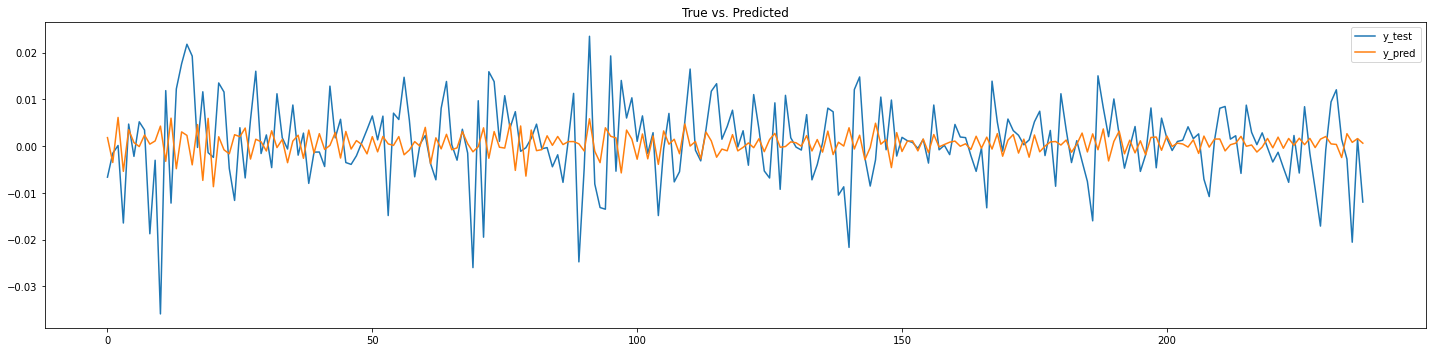

Validation Scores
root mean squared error: 0.0090396595
mean squared error: 8.17154e-05
mean absolute error: 0.0066649795
R2: -0.1198619304


In [27]:
fig_true_vs_fit = mval.get_model_performance()

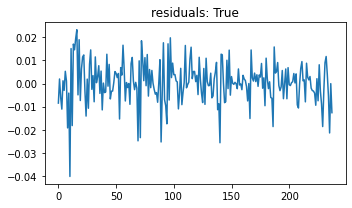

Stationarity Test Results
P-Values: 8.474122107833917e-07
Test-stats: -5.681300696257963
Time series is stationary: True
Number of lags used: 7




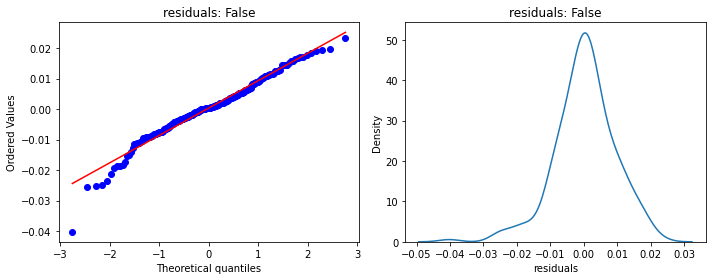

Normality Test Results
P-Values: 7.718234903177799e-06
Test-stats: 23.543849719108646
Series is normally distributed: False


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


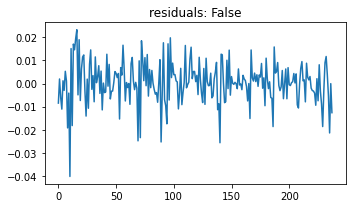

Test for Heteroskedasticity
Test p-value: 0.15802743319111817
Heteroskedasticity is present: False


TTest one sample for mean: 0
Test statistics: 0.6625581592492614
Test pvalue: 0.5082573774904281
Population mean is equal to 0: False


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 2.164 < 2.5
First order autocorrlation is not present: : True


In [28]:
stat, norm, hetero, d_watson, zero_mean = mval.analyse_resids()

In [56]:
# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(d_watson_aucorr=d_watson)
data_dict["model_metrics"].update(aic=mval.model_wrapper.model.trained_model.aic)
data_dict["model_metrics"].update(bic=mval.model_wrapper.model.trained_model.bic)

# model performance
data_dict["model_metrics"].update(rmse=mval.rmse)
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

data_dict['model_metrics'].update(y_pred=mval.model_wrapper.y_pred)
data_dict['model_metrics'].update(y_test=mval.model_wrapper.y_test)

# Save model

In [57]:
save_model(model=mval.model_wrapper, 
           df_train=df_train,
           data_dict=data_dict,
           plt_figures=[fig_true_vs_fit,
                        fig_aic], 
           fig_titles=['fig_truefit', 'fig_aic'],
           model_dir=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-04-05_arma_daily_FF_TS_VX_years2021_2012_sp_close_lead1"? (y/n)


 y
DIR EXISTS: DO YOU WANT TO REPLACE IT? (y/n) y
